# Importing libraries:

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tabulate import tabulate

In [2]:
# loading the dataset
df = pd.read_csv('TUANDROMD.csv')
df.head(5)

,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,malware
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,malware
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,malware
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,malware
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,malware


In [3]:
df.shape

(4465, 242)

# Preprocessing

Dataset has 4465 rows with 242 columns, all of them are encoded with LabelEncoder (binary, only 0 or 1) except variable Label. Next is checking for NaN values and constant/monotonic features.

In [4]:
df.isna().sum()

,0
ACCESS_ALL_DOWNLOADS,1
ACCESS_CACHE_FILESYSTEM,1
ACCESS_CHECKIN_PROPERTIES,1
ACCESS_COARSE_LOCATION,1
ACCESS_COARSE_UPDATES,1
...,...
Landroid/telephony/TelephonyManager;->getSimOperatorName,1
Landroid/telephony/TelephonyManager;->getSimCountryIso,1
Landroid/telephony/TelephonyManager;->getSimSerialNumber,1
Lorg/apache/http/impl/client/DefaultHttpClient;->execute,1


In [5]:
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print("Constant columns: ", constant_cols)

monotonic_cols = [col for col in df.columns if df[col].is_monotonic_increasing or df[col].is_monotonic_decreasing]
print("\nMonotonic columns:", monotonic_cols)

Constant columns:  ['ACCESS_PROVIDER', 'ACCESS_SERVICE', 'ACCESS_SHARED_DATA', 'activityCalled', 'ACTIVITY_RECOGNITION', 'ANT', 'ANT_ADMIN', 'AUTORUN_MANAGER_LICENSE_MANAGER', 'AUTORUN_MANAGER_LICENSE_SERVICE(.autorun)', 'BIND_GET_INSTALL_REFERRER_SERVICE', 'CHANGE_DISPLAY_MODE', 'CHECK_LICENSE', 'DATABASE_INTERFACE_SERVICE', 'DOWNLOAD_SERVICE', 'EXTENSION_PERMISSION', 'FULLSCREEN.FULL', 'GOOGLE_AUTH', 'GOOGLE_PHOTOS', 'JPUSH_MESSAGE', 'MAPS_RECEIVE', 'MESSAGE', 'PERMISSION', 'PERMISSION_RUN_TASKS', 'PLUGIN', 'READ', 'READ_ATTACHMENT', 'READ_AVESTTINGS', 'READ_CONTENT_PROVIDER', 'READ_DATA', 'READ_DATABASES', 'READ_GMAIL', 'READ_GSERVICES', 'READ_MESSAGES', 'RECEIVE', 'RECEIVE_SIGNED_DATA_RESULT', 'RESPOND', 'REQUEST', 'SEND', 'WRITE', 'WRITE_AVSETTING', 'WRITE_DATA', 'WRITE_DATABASES']

Monotonic columns: []


We will remove constant columns because they do not contribute to our model's predictions. If all values in a column are the same, they do not provide any useful information for defining the output.

In [6]:
# removing NaN values, 1 row
df = df.dropna()
df.shape

(4464, 242)

In [7]:
df = df.drop(columns=constant_cols)
df.shape

(4464, 200)

In [8]:
#df.duplicated().sum()

In [9]:
df.Label

,Label
0,malware
1,malware
2,malware
3,malware
4,malware
...,...
4460,goodware
4461,goodware
4462,goodware
4463,goodware


We have to LabelEncode our Label; right now it is type object, but for our training we need type int.

In [10]:
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
df.head(1)

,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1


## Checking class balance

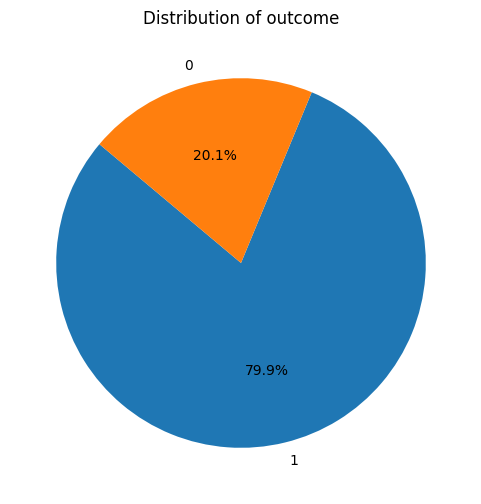

Count for eaach class:
 Label
1    3565
0     899
Name: count, dtype: int64


In [11]:
label_counts = df['Label'].value_counts()
# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of outcome")
plt.show()

print("Count for eaach class:\n", label_counts)

The problem is we have a very big class imbalance. If we leave it as it is, our model will be biased for the class 1 - 'malware' because it will learn from malware-related features. The model would not generalize good. So we will have to apply **undersampling** to reduce the size of class 1.

In [ ]:
y = df['Label']
X = df.drop(columns= ['Label'])

rus = RandomUnderSampler(random_state=42)             # resource: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
X_resampled, y_resampled = rus.fit_resample(X, y)

In [13]:
label_counts = y_resampled.value_counts()
print("Count for eaach class:\n", label_counts)

Count for eaach class:
 Label
0    899
1    899
Name: count, dtype: int64


# Dimensionality reduction

We have too many features - 200; which means probably not all of them give valueable information for our model. We need to reduce that number. Highly correlated features are not good for our model - we need to simplify our model and reduce high dimensionality.
We are using PCA for reduction but before that we have to standardize our values.

In [ ]:
'''
corr_matrix = df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
df = df.drop(columns=to_drop)
df.shape
'''
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# resource: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("Number of components selected: ", pca.n_components_)

Number of components selected:  68


# Splitting the dataset and training + evaluation and results

Now we will use K-Fold cross validation with K=10 as used in our article.

In [ ]:
def try_models(X_train, X_test, y_train, y_test):
    k = 10
    models = ["Random Forest", "Extra Trees", "AdaBoost", "XGBoost", "Gradient Boosting"]
    results = {}
    accuracies = {}

    # Random Forest
    model_rf = RandomForestClassifier()
    cv_rf = cross_val_score(model_rf, X_train, y_train, cv=k)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    results["Random Forest"] = classification_report(y_test, y_pred_rf, target_names=['Benign', 'Malware'], digits=4)
    accuracies["Random Forest"] = np.mean(cv_rf) * 100  

    # Extra Trees
    model_et = ExtraTreesClassifier()
    cv_et = cross_val_score(model_et, X_train, y_train, cv=k)
    model_et.fit(X_train, y_train)
    y_pred_et = model_et.predict(X_test)
    results["Extra Tree"] = classification_report(y_test, y_pred_et, target_names=['Benign', 'Malware'], digits=4)
    accuracies["Extra Tree"] = np.mean(cv_et) * 100  

    # AdaBoost
    model_ab = AdaBoostClassifier()
    cv_ab = cross_val_score(model_ab, X_train, y_train, cv=k)
    model_ab.fit(X_train, y_train)
    y_pred_ab = model_ab.predict(X_test)
    results["Ada Boost"] = classification_report(y_test, y_pred_ab, target_names=['Benign', 'Malware'], digits=4)
    accuracies["Ada Boost"] = np.mean(cv_ab) * 100  

    # XGB
    model_xgb = XGBClassifier()
    cv_xgb = cross_val_score(model_xgb, X_train, y_train, cv=k)
    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)
    results["XG Boost"] = classification_report(y_test, y_pred_xgb, target_names=['Benign', 'Malware'], digits=4)
    accuracies["XG Boost"] = np.mean(cv_xgb) * 100  
    
    # Gradient Boosting
    model_gb = GradientBoostingClassifier()
    cv_gb = cross_val_score(model_gb, X_train, y_train, cv=k)
    model_gb.fit(X_train, y_train)
    y_pred_gb = model_gb.predict(X_test)
    results["Gradient Boosting"] = classification_report(y_test, y_pred_gb, target_names=['Benign', 'Malware'], digits=4)
    accuracies["Gradient Boosting"] = np.mean(cv_gb) * 100  # Mean cross-validation accuracy

    return results, accuracies

In [16]:
def print_classification_report(results):
    for model, report in results.items():
        print(f"Classification Report for {model}:\n")
        print(report)
        print("-" * 50)

In [17]:
def print_article_results(accuracies):
    # Results data
    classifiers = [
        "Random Forest", "Extra Tree", "Ada Boost", "XG Boost", "Gradient Boosting"
    ]

    tuandromd_accuracies = [98.7, 98.8, 97.9, 97.8, 97.4]

    results = [ [classifiers[i], tuandromd_accuracies[i], accuracies[classifiers[i]]]
        for i in range(len(classifiers))]

    headers = ['Model', 'TUANDROMD Accuracy', 'Current Model Acc']
    print(tabulate(results, headers=headers, floatfmt=".4f"))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_resampled, test_size=0.2, random_state=42)

In [19]:
results, accuracies = try_models(X_train, X_test, y_train, y_test)

In [20]:
print_classification_report(results)
print()
print_article_results(accuracies)

Classification Report for Random Forest:

              precision    recall  f1-score   support

      Benign     0.9672    0.9944    0.9806       178
     Malware     0.9944    0.9670    0.9805       182

    accuracy                         0.9806       360
   macro avg     0.9808    0.9807    0.9806       360
weighted avg     0.9809    0.9806    0.9806       360

--------------------------------------------------
Classification Report for Extra Tree:

              precision    recall  f1-score   support

      Benign     0.9672    0.9944    0.9806       178
     Malware     0.9944    0.9670    0.9805       182

    accuracy                         0.9806       360
   macro avg     0.9808    0.9807    0.9806       360
weighted avg     0.9809    0.9806    0.9806       360

--------------------------------------------------
Classification Report for Ada Boost:

              precision    recall  f1-score   support

      Benign     0.9721    0.9775    0.9748       178
     Malware    